In [1]:
try:
    # import google.colab # type: ignore
    # from google.colab import output
    %pip install -q transformer-lens matplotlib numpy seaborn torch hf_transfer tqdm scikit-learn
except:
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import json
import random
import transformers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from grid_functions import *
from transformer_lens import HookedTransformer

import os
# Avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# My imports
from dataset import GridTextDataset
from dataset import get_dataloader
from analysis import *
from plotting import plot_color_gradients, generate_colormap
from relative_goal_hypothesis import collect_all_activations, collect_activations_table

In [3]:
transformers.__version__

'4.57.3'

## Loading Model

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# if the model is not downloaded, this might be needed

#access_token = "hf_TOKEN"

#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)
#model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B", token=access_token)

In [5]:
# Load the model using transformer-lens
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


## Load Data

In [6]:
# test loading
with open("data/grid_simple_dataset.json", "r") as f:
    loaded_dataset = json.load(f)

Vizualize one point of the dataset on the grid

In [7]:
torch_dataset = GridTextDataset(loaded_dataset, train_ratio=1.0, valid_ratio=0.0)
torch_dataset.__getitem__(0)  # Test getting the first item

train_loader, valid_loader, test_loader = get_dataloader(loaded_dataset, batch_size=8, train_ratio=1.0, valid_ratio=0.0)

Training dataset len: 600
Validation dataset len: 0
Test dataset len: 0


Text form:
You are solving a grid navigation task.

The grid is 5x5.
Coordinates are (x, y).
x increases to the RIGHT.
y increases DOWN.
The top-left cell is (0, 0).

Agent position: (0, 1)
Goal position: (4, 2)

Reason step by step about the spatial relationship.
Then write:

ACTION:
Visualizing grid:


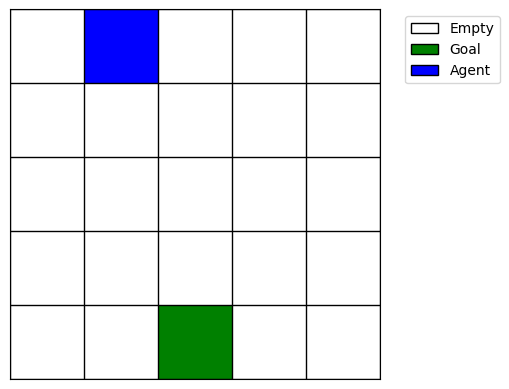

In [8]:
for batch in train_loader:
    text = batch["text"][0]
    type_text = batch["text_type"][0]
    goal_grid = batch["goal_grid"][0]
    agent_grid = batch["agent_grid"][0]
    print("Text form:")
    print(text)
    print("Visualizing grid:")
    visualize_binary_grid(goal_grid, agent_grid, 5, 5)
    break

## All layers PCA

In [9]:
import torch
import torch.nn.functional as F
import numpy as np
from grid_functions import generate_simple_example


def collect_all_activations(model, test_loader, device="cuda"):
    # For PCA
    model.eval()

    n_layers = model.cfg.n_layers

    x = []
    y_goal = []
    y_agent = []

    with torch.no_grad():
        for batch in test_loader:
            text = batch["text"]
            goal_grid = batch["goal_grid"].to(device)
            agent_grid = batch["agent_grid"]

            _, cache = model.run_with_cache(text)

            all_acts = [
                cache["resid_pre", layer][:, -1]
                for layer in range(n_layers)
            ]  # list: [batch, hidden]
            all_acts = torch.stack(all_acts, dim=1)

            all_acts = all_acts.reshape(all_acts.shape[0], -1)
            x.append(all_acts.cpu())
            y_goal.append(goal_grid.cpu())
            y_agent.append(agent_grid.cpu())

    return torch.cat(x, dim=0), torch.cat(y_goal, dim=0), torch.cat(y_agent, dim=0)

In [10]:
all_activations_x, y_goals, y_agents = collect_all_activations(model, train_loader)

In [11]:
y_goals_flat = torch.argmax(y_goals, axis=1)
y_agents_flat = torch.argmax(y_agents, axis=1)

In [12]:
reduced_data_pca = PCA(n_components=3).fit_transform(all_activations_x)
cmap = generate_colormap(25)

### Agent position clusters

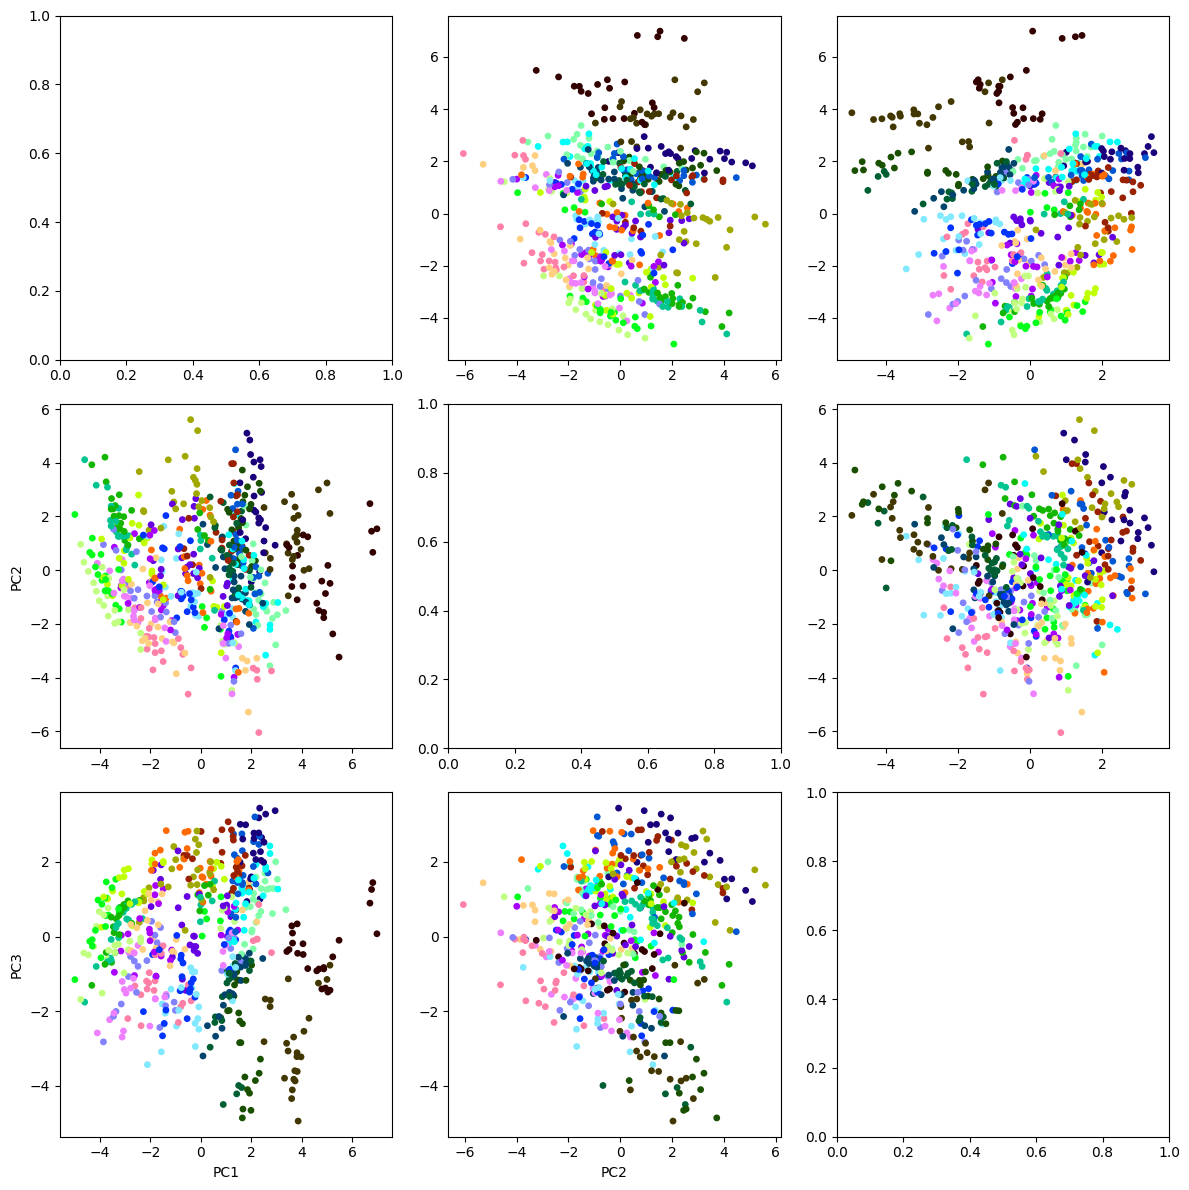

Silhouette score:  -0.023787482301327333
Davies Bouldin Score:  3.26372612028485


In [13]:
# Agent pos
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_agents_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()


score = silhouette_score(reduced_data_pca, y_agents_flat)
db = davies_bouldin_score(reduced_data_pca, y_agents_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

### Goal position clusters

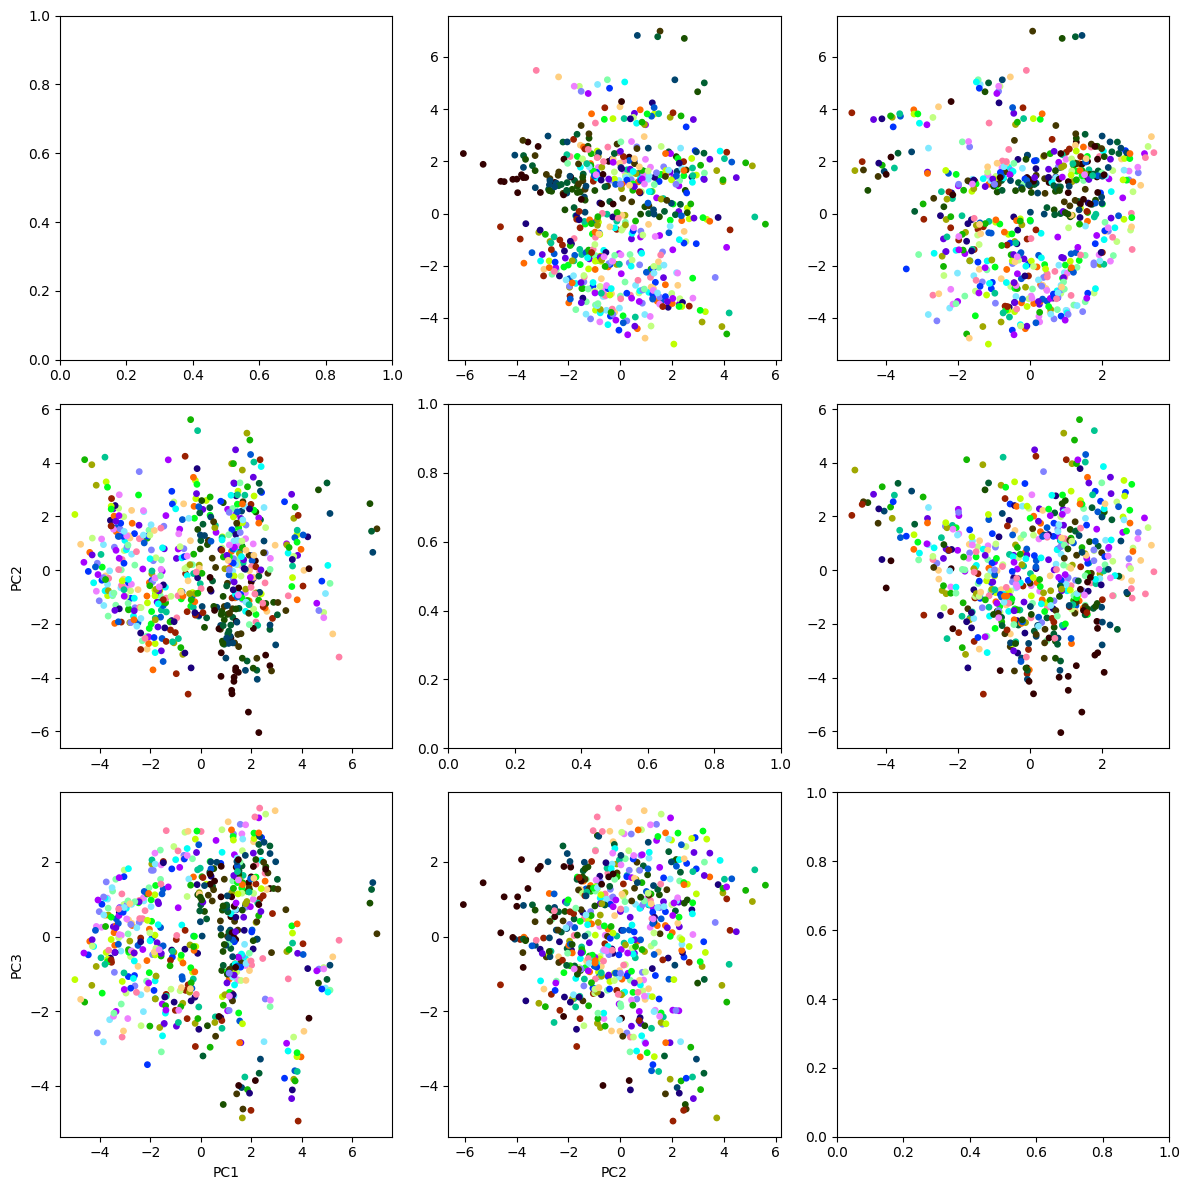

Silhouette score:  -0.14202821005801164
Davies Bouldin Score:  23.54063655403986


In [14]:
# Goals pos
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_goals_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()

score = silhouette_score(reduced_data_pca, y_goals_flat)
db = davies_bouldin_score(reduced_data_pca, y_goals_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

## Layer 29 PCA

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
from grid_functions import generate_simple_example


def collect_all_activations(model, test_loader, device="cuda"):
    # For PCA
    model.eval()

    n_layers = model.cfg.n_layers

    x = []
    y_goal = []
    y_agent = []

    with torch.no_grad():
        for batch in test_loader:
            text = batch["text"]
            goal_grid = batch["goal_grid"].to(device)
            agent_grid = batch["agent_grid"]

            _, cache = model.run_with_cache(text)

            all_acts = [
                cache["resid_pre", 29][:, -1]
            ]  # list: [batch, hidden]
            all_acts = torch.stack(all_acts, dim=1)

            all_acts = all_acts.reshape(all_acts.shape[0], -1)
            x.append(all_acts.cpu())
            y_goal.append(goal_grid.cpu())
            y_agent.append(agent_grid.cpu())

    return torch.cat(x, dim=0), torch.cat(y_goal, dim=0), torch.cat(y_agent, dim=0)

In [16]:
all_activations_x, y_goals, y_agents = collect_all_activations(model, train_loader)

In [17]:
y_goals_flat = torch.argmax(y_goals, axis=1)
y_agents_flat = torch.argmax(y_agents, axis=1)

In [18]:
reduced_data_pca = PCA(n_components=3).fit_transform(all_activations_x)
cmap = generate_colormap(25)

### Agent pos cluster

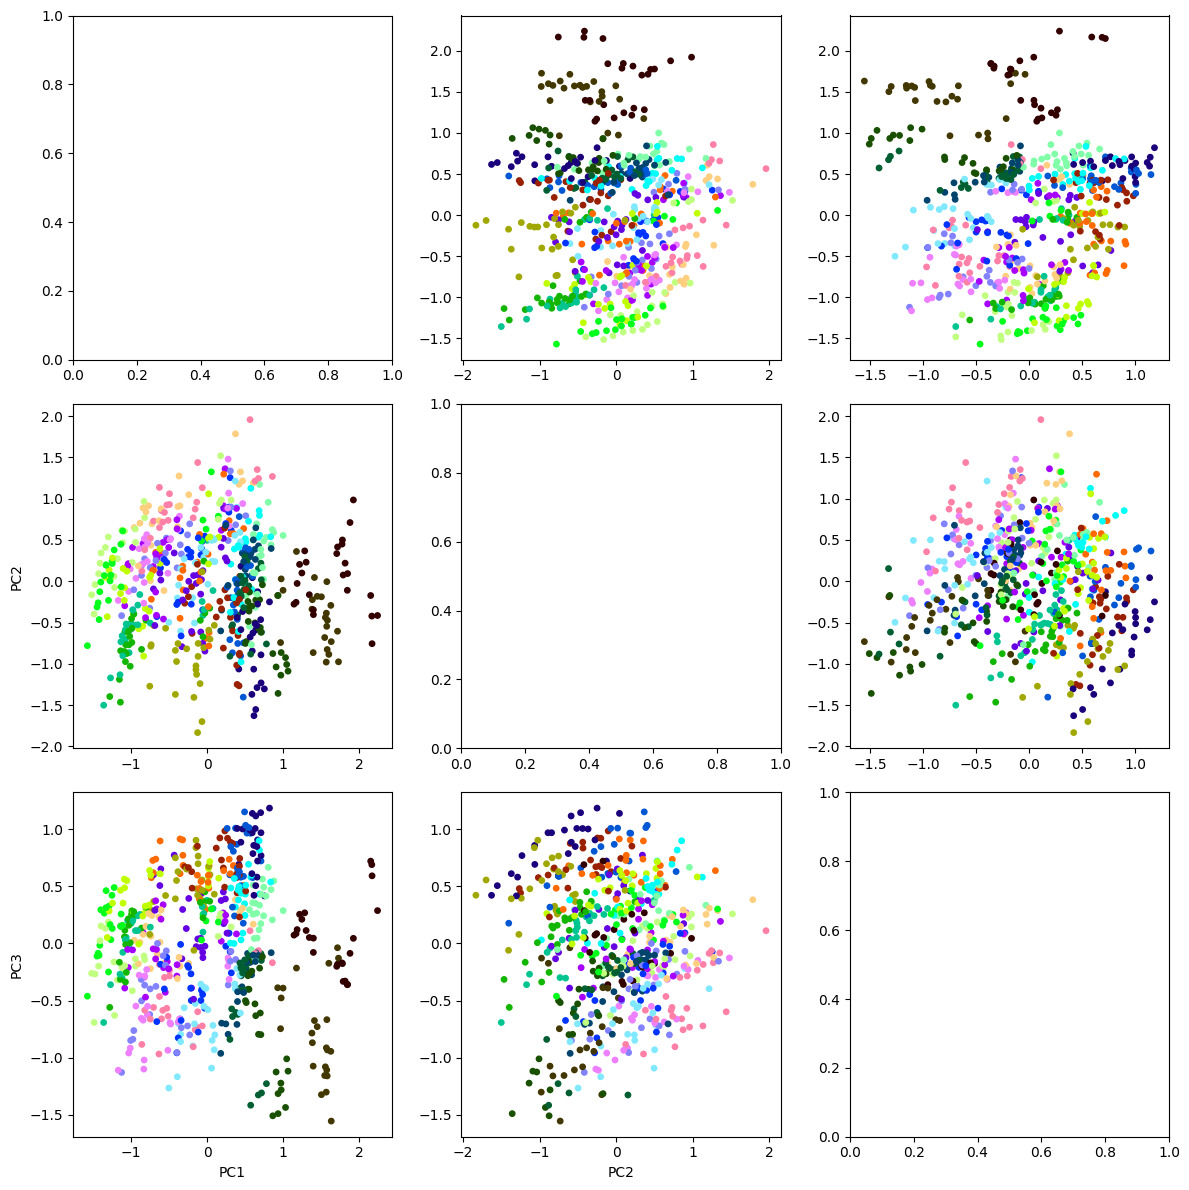

Silhouette score:  -0.022065913536986604
Davies Bouldin Score:  3.1665362000002757


In [20]:
# Agents pos labels
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_agents_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()

score = silhouette_score(reduced_data_pca, y_agents_flat)
db = davies_bouldin_score(reduced_data_pca, y_agents_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)

### Goal pos cluster

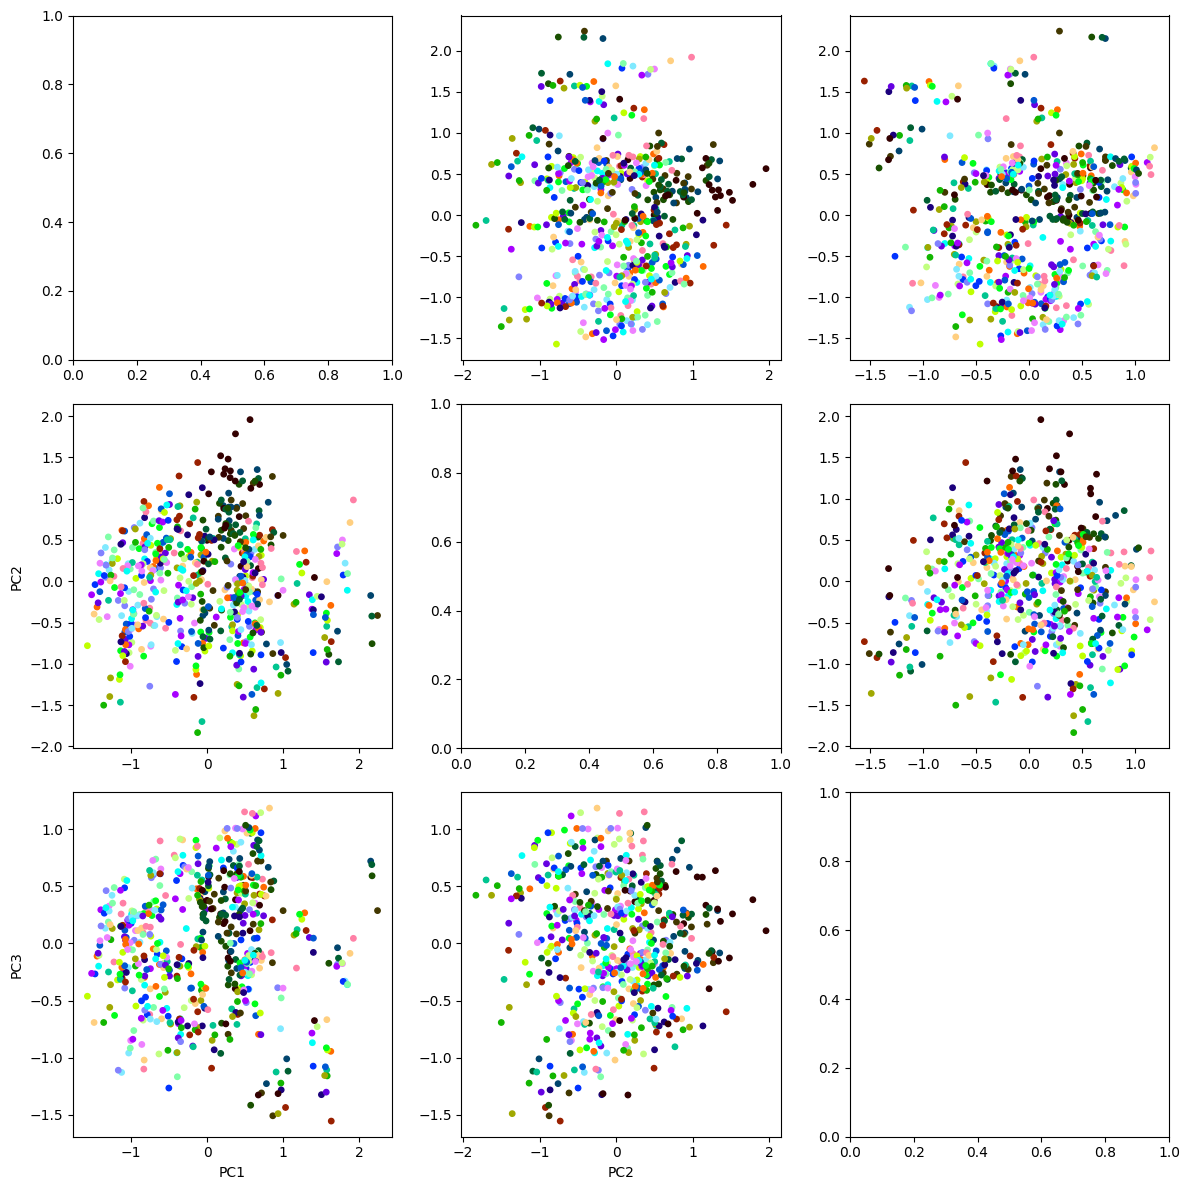

Silhouette score:  -0.1397197930711874
Davies Bouldin Score:  25.361968424523514


In [21]:
# Goals pos labels
# Number of PCA components
n_components = reduced_data_pca.shape[1]

fig, axes = plt.subplots(n_components, n_components, figsize=(12, 12))

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            continue
        else:
            # Off-diagonal: scatter plot
            sc = ax.scatter(
                reduced_data_pca[:, j], 
                reduced_data_pca[:, i], 
                c=y_goals_flat, 
                cmap=cmap, 
                s=15
            )
        if i == n_components - 1:
            ax.set_xlabel(f'PC{j+1}')
        if j == 0:
            ax.set_ylabel(f'PC{i+1}')

plt.tight_layout()
plt.show()
score = silhouette_score(reduced_data_pca, y_goals_flat)
db = davies_bouldin_score(reduced_data_pca, y_goals_flat)
print("Silhouette score: ", score)
print("Davies Bouldin Score: ", db)